# Searching in a transformed space

In the previous notebook we set up boundaries and created a method to sample from within them.
When doing this, we found it useful to replace some parameter values with their logarithm.
In this notebook we extend this log-transformation approach to the optimisation routine, so that we search in a (partly) log-transformed space.

## Why transform the search space?

Before performing parameter estimation it _can_ be a good idea to perform some kind of transformations on the search space.
For example, some optimisation methods don't perform well on spaces where the error measure varies very rapidly in one direction, but slowly in another.
In these cases it might help to rescale the parameters, e.g. so that they are all restricted to the interval $[0, 1]$.

For the "a-type" parameters in our model, [Beattie et al.](https://doi.org/10.1113/JP275733) found that the prior expectation was that they'd vary over many orders of magnitude.
As a result, it seemed sensible to use a log-transformation on these parameters when searching, which led to notably improved results.
Experimental confirmation of this approach was provided in the supplemental results to ["Four Ways to Fit an Ion Channel Model"](https://doi.org/10.1016/j.bpj.2019.08.001), section S2.4.2.

While there is no catch-all strategy that we know of, it may be a good idea to try several transformations when dealing with a difficult parameter estimation problem.
The following section will show how.

## Implementing transformations in PINTS

In this section, we'll set up a synthetic data problem with a forward model and boundaries, and then use PINTS' [Transformation classes](https://pints.readthedocs.io/en/latest/transformations.html) to perform the log transformations.

We start by defining an optimisation problem, just like in previous notebooks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import myokit
import pints

# Load a protocol and create a foward model instance
from library import ModelHHSolver as Model
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

# Seed numpy, just so that the notebook shows the same results each time
np.random.seed(3)

# Set up a synthetic data problem and error
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.025, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Create boundaries and take a random sample as initial starting point
from library import Boundaries
boundaries = Boundaries()

# Make a random guess for the parameters
x0 = boundaries.sample(1)[0]

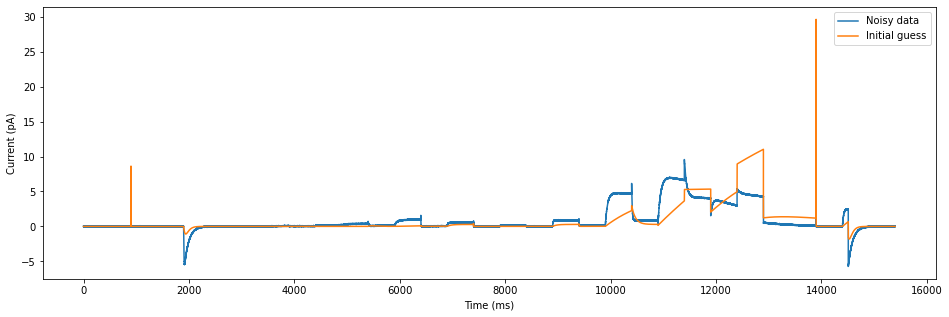

In [3]:
# Visualise the data and starting point
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.legend()
plt.show()

But this time, we also define a transformation object that can translate parameter vectors from "model space" to "search space".
To create this 9-dimensional transformation, we use a [pints.ComposedTransformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.ComposedTransformation) to join nine 1-dimensional transformations together.
We'll use a [LogTransformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.LogTransformation) for the a-type parameters, and an [IdentifyTransformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.IdentityTransformation) (which does nothing!) for the rest.

In [4]:
transform = pints.ComposedTransformation(
    pints.LogTransformation(n_parameters=1),       # p1 (a-type)
    pints.IdentityTransformation(n_parameters=1),  # p2 (b-type)
    pints.LogTransformation(n_parameters=1),       # p3 (a-type)
    pints.IdentityTransformation(n_parameters=1),  # p4 (b-type)
    pints.LogTransformation(n_parameters=1),       # p5 (a-type)
    pints.IdentityTransformation(n_parameters=1),  # p6 (b-typ)
    pints.LogTransformation(n_parameters=1),       # p7 (a-type)
    pints.IdentityTransformation(n_parameters=1),  # p8 (b-type)
    pints.IdentityTransformation(n_parameters=1),  # p9 (maximum conductance)
)

We can test our class out by converting a point from "model space" (untransformed) to "search space" (log transformed):

In [5]:
x = np.array([10]*9)
print(x)

y = transform.to_search(x)
print(y)

z = transform.to_model(y)
print(z)

[10 10 10 10 10 10 10 10 10]
[ 2.30258509 10.          2.30258509 10.          2.30258509 10.
  2.30258509 10.         10.        ]
[10. 10. 10. 10. 10. 10. 10. 10. 10.]


To use this transformation, we simply pass it to the OptimisationController object on construction.

In [6]:
# Run an optimisation in a transformed space
opt = pints.OptimisationController(
    error,
    x0,
    boundaries=boundaries,
    transform=transform  # Pass the transformation to the optimiser
)
opt.set_parallel(True)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     9      1.615832   0:00.1
1     19     1.420464   0:00.1
2     29     1.420464   0:00.2
3     38     1.33436    0:00.2
20    198    1.255269   0:00.6
40    398    1.196722   0:01.2
60    593    0.868      0:01.7
80    781    0.831      0:02.2
100   981    0.819      0:02.8
120   1161   0.756      0:03.3
140   1351   0.662      0:03.8
160   1551   0.568      0:04.4
180   1748   0.521      0:04.9
200   1948   0.336      0:05.4
220   2148   0.279      0:06.0
240   2348   0.249      0:06.5
260   2548   0.239279   0:07.1
280   2737   0.229      0:07.6
300   2904   0.223      0:08.1
320   3073   0.214      0:08.6
340   3261   0.21       0:09.2
360   3458   0.208      0:09.7
380   3658   0.207      0:10.2
400   3858   0.035      0:10.7
420   4058   0.00679    0:11.3
440   4258   0.00291    0:11.8
460   445

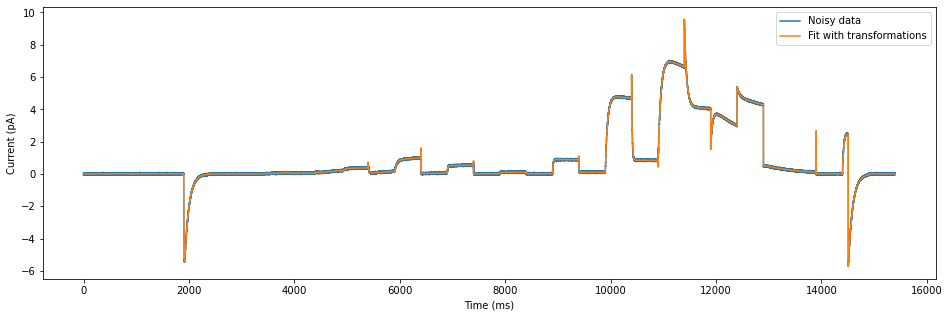

In [7]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='Fit with transformations')
plt.legend()
plt.show()

For comparison, we re-run without transformations.

In [8]:
opt = pints.OptimisationController(
    error,
    x0,
    boundaries=boundaries
)
opt.set_parallel(True)
x2, f2 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     2.140075   0:00.1
1     20     1.996757   0:00.1
2     30     1.906599   0:00.1
3     40     1.785501   0:00.2
20    210    1.152691   0:00.6
40    409    1.14104    0:01.1
60    609    1.139324   0:01.6
80    809    1.138925   0:02.2
100   1009   1.138685   0:02.7
120   1209   1.137247   0:03.3
140   1409   1.126504   0:03.9
160   1600   1.078124   0:04.5
180   1769   0.664      0:04.9
200   1925   0.484      0:05.4
220   2066   0.427      0:05.9
240   2227   0.398      0:06.4
260   2378   0.354      0:06.9
280   2536   0.306      0:07.4
300   2689   0.277      0:07.8
320   2868   0.24       0:08.3
340   3046   0.236709   0:08.8
360   3237   0.22       0:09.4
380   3419   0.202      0:10.0
400   3614   0.2        0:10.5
420   3814   0.198      0:11.2
440   4014   0.197      0:12.1
460   421

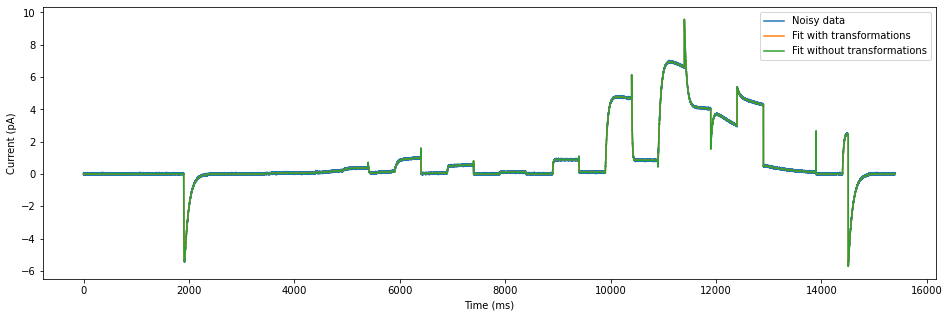

In [9]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='Fit with transformations')
plt.plot(times, problem.evaluate(x2), label='Fit without transformations')
plt.legend()
plt.show()

So both fits find the same results but (with this particular random seeding) the optimisation with transformations runs a lot faster, and uses fewer iterations. 

## Summary

In this notebook we have

- Created a Transformation object that can transform between model and search space.
- Used it to run an optimisation in a transformed parameter space.

Some of the classes we've created here will be useful in the upcoming notebooks, so we've stored them in the file [library.py](library.py).

In the next notebook, we'll take a look at the practical side of running several repeated fitting experiments.